In [15]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import os
import json
import requests
import zipfile
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from scipy.spatial import distance
import matplotlib.pyplot as plt


In [16]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Step 1: Download & Extract COCO Validation Set (~2GB)
!mkdir -p coco && cd coco && \
    wget http://images.cocodataset.org/zips/val2017.zip && \
    unzip -q val2017.zip && rm val2017.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip && \
    unzip -q annotations_trainval2017.zip && rm annotations_trainval2017.zip

--2025-02-22 15:14:02--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.64.33, 16.15.200.160, 52.216.59.41, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.64.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  95.4MB/s    in 8.1s    

2025-02-22 15:14:11 (95.7 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2025-02-22 15:14:16--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.176.192, 3.5.20.102, 54.231.197.97, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.176.192|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100

In [17]:
# Step 2: Load COCO Annotations
with open("annotations/instances_val2017.json", 'r') as f:
    coco_annotations = json.load(f)

In [18]:
# Select 5-10 classes
selected_classes = ['person', 'car', 'dog', 'cat', 'airplane', 'bottle']

In [19]:
# Map class names to COCO category IDs
category_map = {c['id']: c['name'] for c in coco_annotations['categories']}
selected_cat_ids = [k for k, v in category_map.items() if v in selected_classes]

In [20]:
# Get image paths for selected classes
image_paths = []
image_labels = []
for ann in coco_annotations['annotations']:
    if ann['category_id'] in selected_cat_ids:
        img_id = ann['image_id']
        img_filename = f"coco/val2017/{img_id:012d}.jpg"
        if os.path.exists(img_filename):
            image_paths.append(img_filename)
            image_labels.append(category_map[ann['category_id']])

In [21]:
# Step 3: Define Dataset & Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class COCODataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = self.transform(img)
        return img.to(device), self.labels[idx]

dataset = COCODataset(image_paths, image_labels, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)


In [11]:
# Step 4: Load Pre-trained Models
def load_model(model_name):
    if model_name == "resnet101":
        model = models.resnet101(pretrained=True)
        model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove last FC layer
    elif model_name == "googlenet":
        model = models.googlenet(pretrained=True)
        model = torch.nn.Sequential(*list(model.children())[:-1])
    elif model_name == "alexnet":  # ZFNet alternative
        model = models.alexnet(pretrained=True)
        model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()
    return model

models_dict = {
    "resnet101": load_model("resnet101"),
    "googlenet": load_model("googlenet"),
    "zfnet": load_model("alexnet")
}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 175MB/s]  
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be remov

In [24]:
# Step 5: Extract Features
def extract_features(model, dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            model = model.to(device)  # Ensure model is on the same device
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten
            features.append(outputs.cpu())
            labels.extend(lbls)
    return torch.cat(features).numpy(), labels

feature_dict = {}
for model_name, model in models_dict.items():
    print(f"Extracting features using {model_name}...")
    feature_dict[model_name] = extract_features(model, dataloader)

Extracting features using resnet101...
Extracting features using googlenet...
Extracting features using zfnet...


In [25]:
# Step 6: Find 10 Nearest Neighbors
def find_nearest_neighbors(features, labels, query_idx, top_k=10):
    query_feature = features[query_idx]
    distances = [distance.euclidean(query_feature, f) for f in features]
    nearest_indices = np.argsort(distances)[1:top_k+1]  # Exclude the query image itself
    return nearest_indices

In [26]:
# Select one image per class
selected_images = {}
for cls in selected_classes:
    idx = image_labels.index(cls)  # Pick first image of each class
    selected_images[cls] = idx

In [27]:
# Compare results across models
for model_name in models_dict.keys():
    print(f"\nResults for {model_name}:")
    features, labels = feature_dict[model_name]
    for cls, img_idx in selected_images.items():
        neighbors = find_nearest_neighbors(features, labels, img_idx)
        print(f"Class {cls} -> Nearest Neighbors: {neighbors}")



Results for resnet101:
Class person -> Nearest Neighbors: [  73  130  265 1057   87 1043  154  588 1231 1247]
Class car -> Nearest Neighbors: [ 164 3117 1600 6183 6169 6179 6176 6582 6551 6657]
Class dog -> Nearest Neighbors: [  322  3386  3373  2497  2366  2946 11884 11947 14332 11860]
Class cat -> Nearest Neighbors: [  45   33   42 5545   40   28 3533 1327   36  131]
Class airplane -> Nearest Neighbors: [1295 1285 1284 1402  261 1015 1003  999 1309 1305]
Class bottle -> Nearest Neighbors: [1179 1324 1056  141  150  566   81  155  567   96]

Results for googlenet:
Class person -> Nearest Neighbors: [1057 1043  154   76   87  130  265 9940 9927 9919]
Class car -> Nearest Neighbors: [ 164 9609 9653 9531 9490 8657 8567 5585 5700 5707]
Class dog -> Nearest Neighbors: [ 322  769  843  874  883 1219  751 1483 1376 1249]
Class cat -> Nearest Neighbors: [1545 5545 3464 1550   24 3475 5538  499   30 1059]
Class airplane -> Nearest Neighbors: [ 1293  1284  1285  1303  1402  1003 14461   999  1

In [28]:
def visualize_neighbors(features, labels, query_idx, image_paths, model_name, top_k=10):
    neighbors = find_nearest_neighbors(features, labels, query_idx, top_k)

    fig, axes = plt.subplots(1, top_k+1, figsize=(20, 5))

    # Show query image
    query_img = Image.open(image_paths[query_idx])
    axes[0].imshow(query_img)
    axes[0].set_title("Query Image")
    axes[0].axis("off")

    # Show nearest neighbors
    for i, neighbor_idx in enumerate(neighbors):
        neighbor_img = Image.open(image_paths[neighbor_idx])
        axes[i+1].imshow(neighbor_img)
        axes[i+1].set_title(f"Neighbor {i+1}")
        axes[i+1].axis("off")

    plt.suptitle(f"Nearest Neighbors using {model_name}", fontsize=16)
    plt.show()



Visualizing results for resnet101:
Class: person


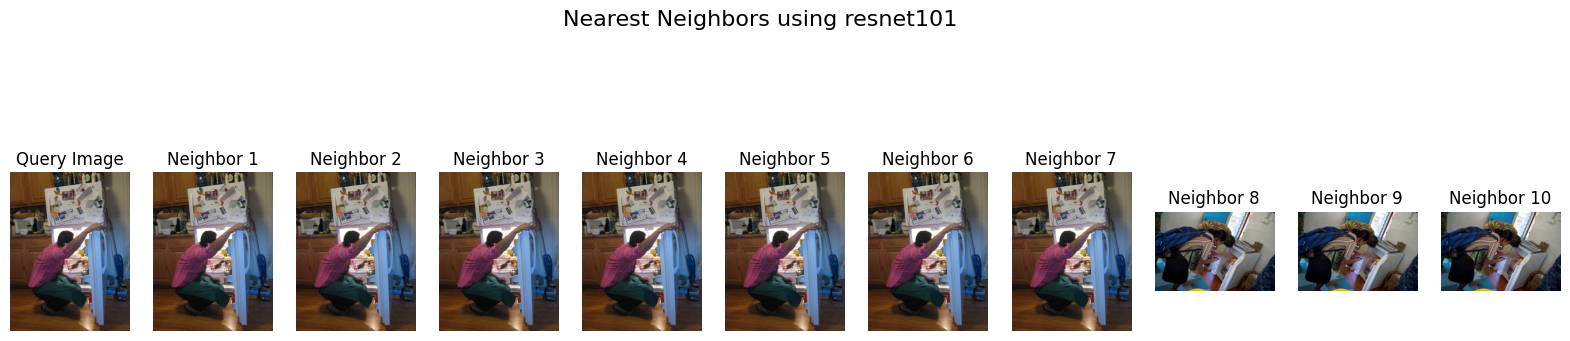

Class: car


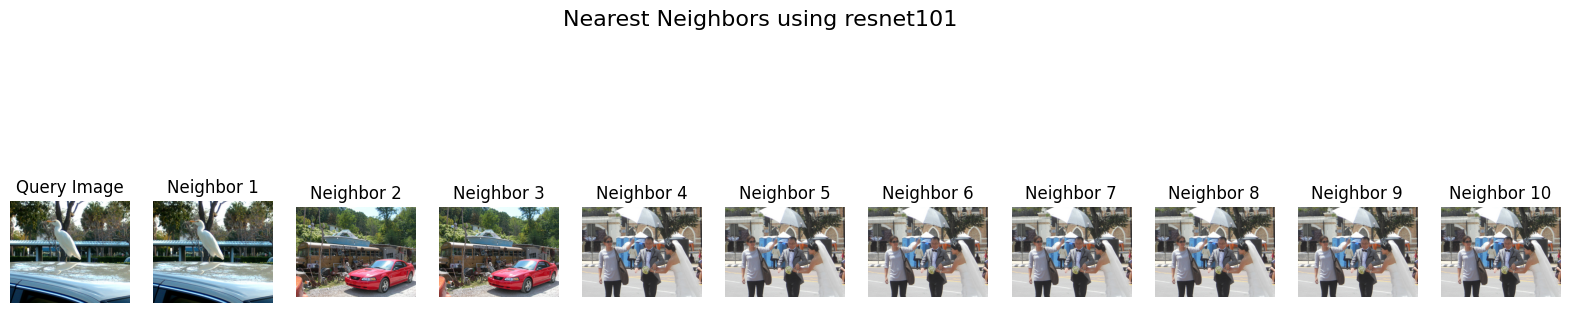

Class: dog


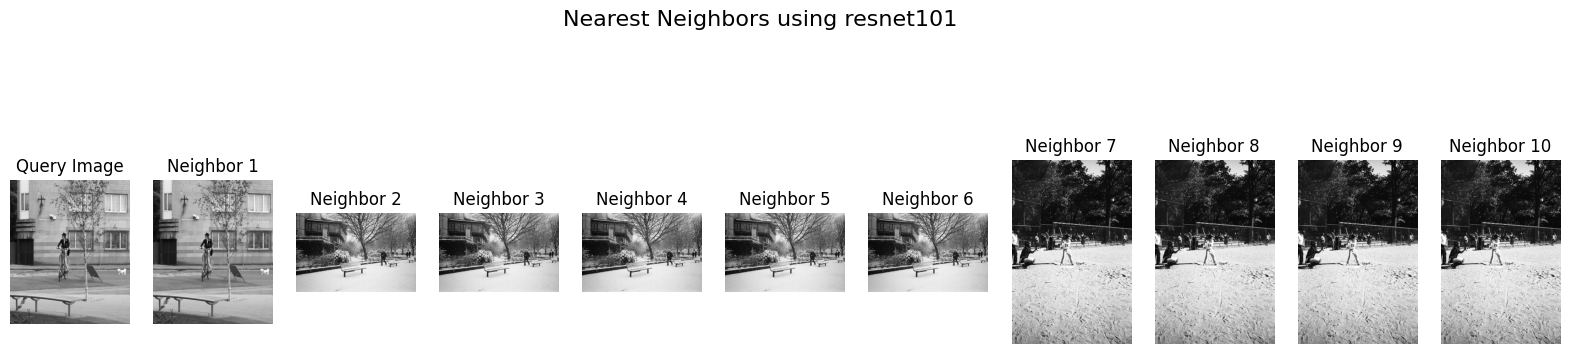

Class: cat


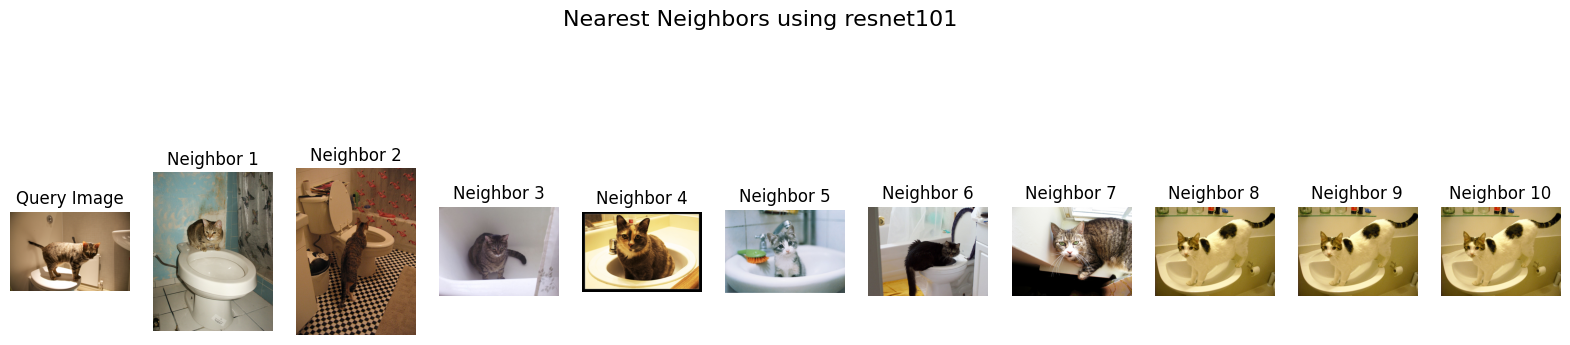

Class: airplane


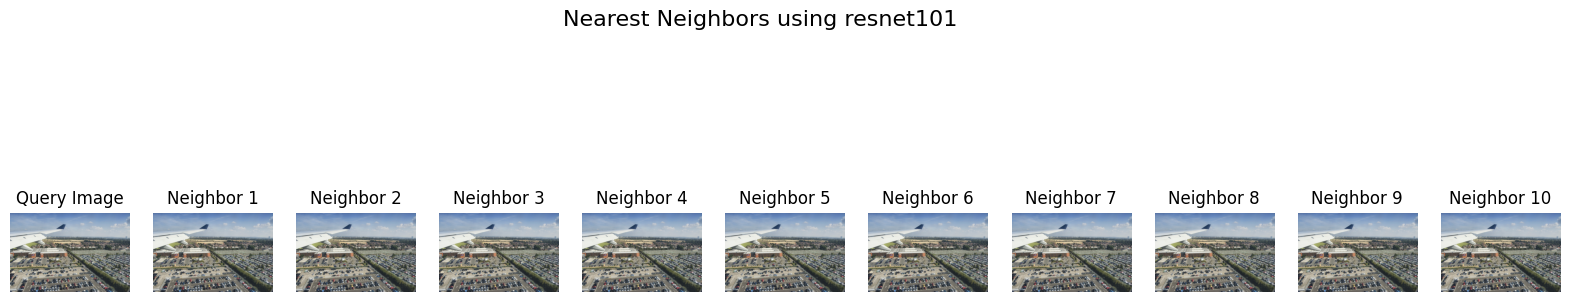

Class: bottle


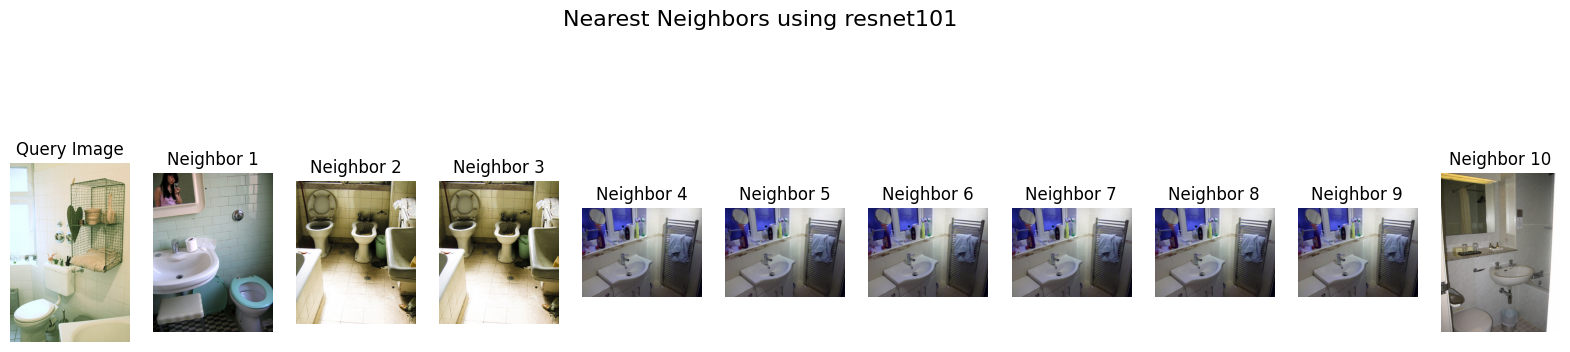


Visualizing results for googlenet:
Class: person


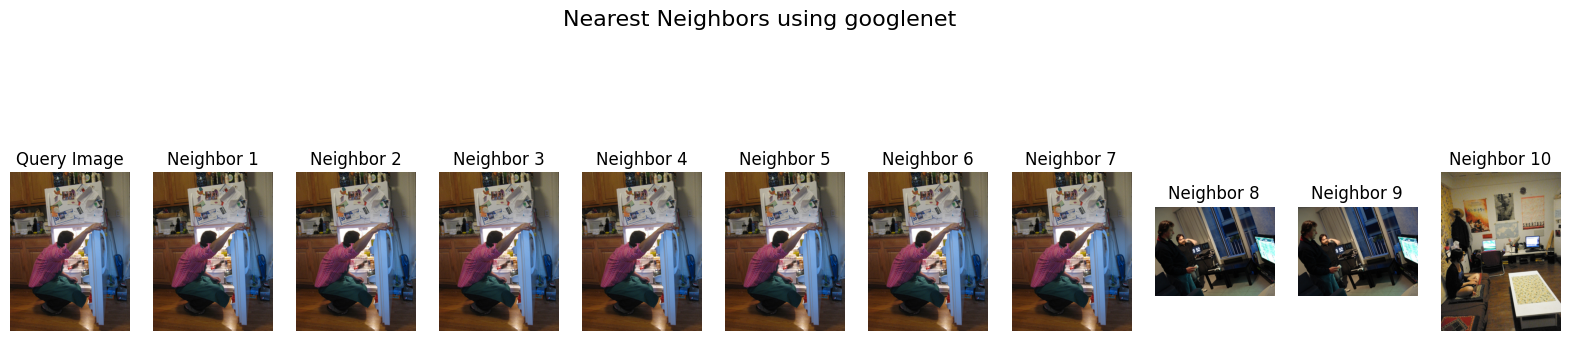

Class: car


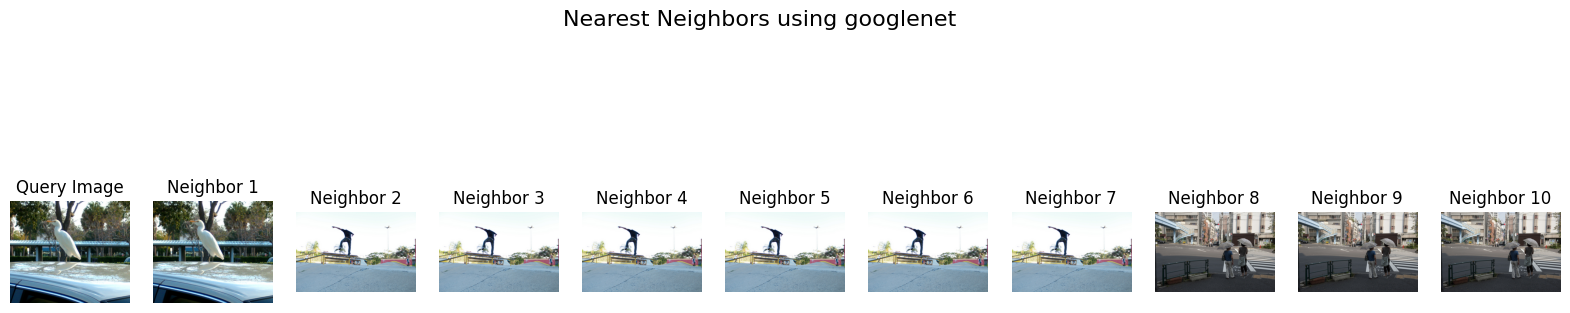

Class: dog


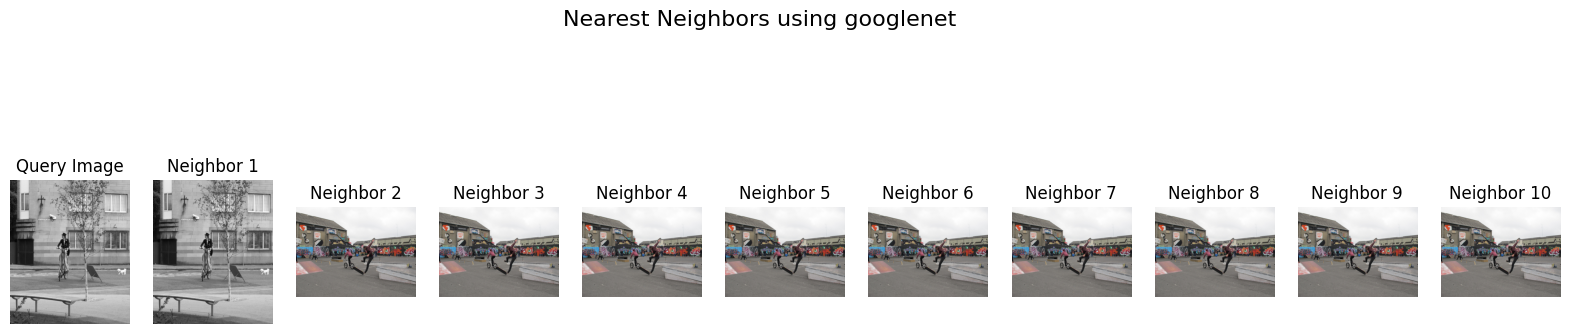

Class: cat


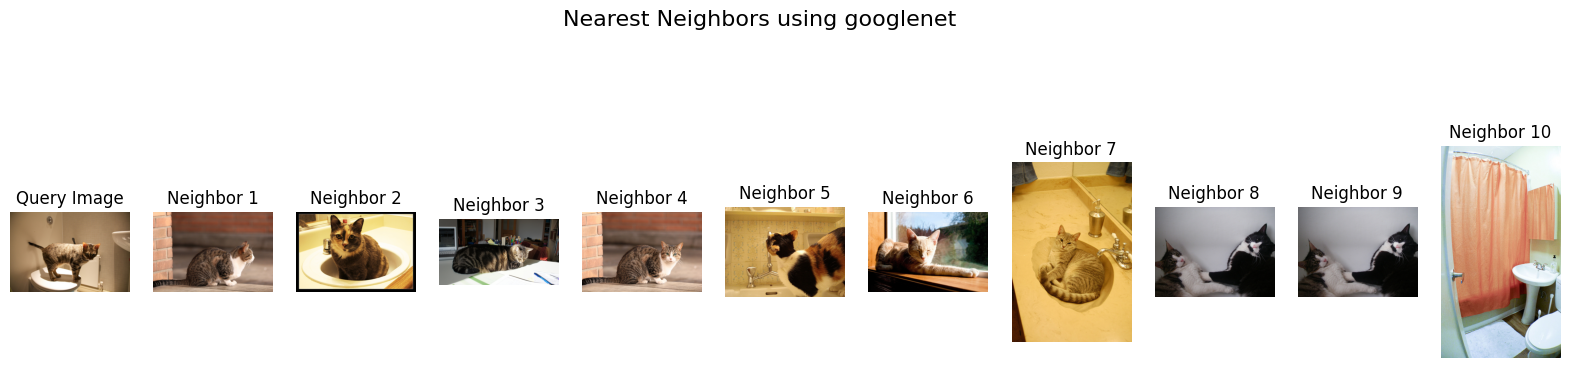

Class: airplane


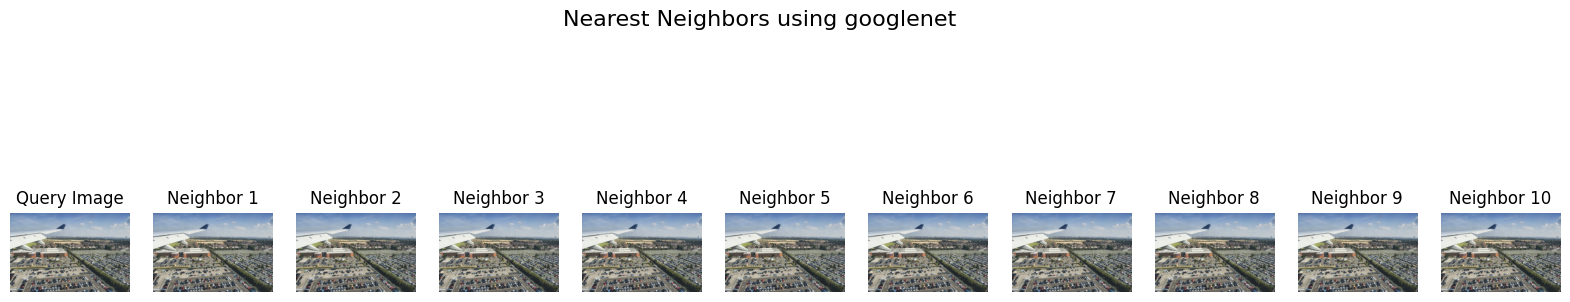

Class: bottle


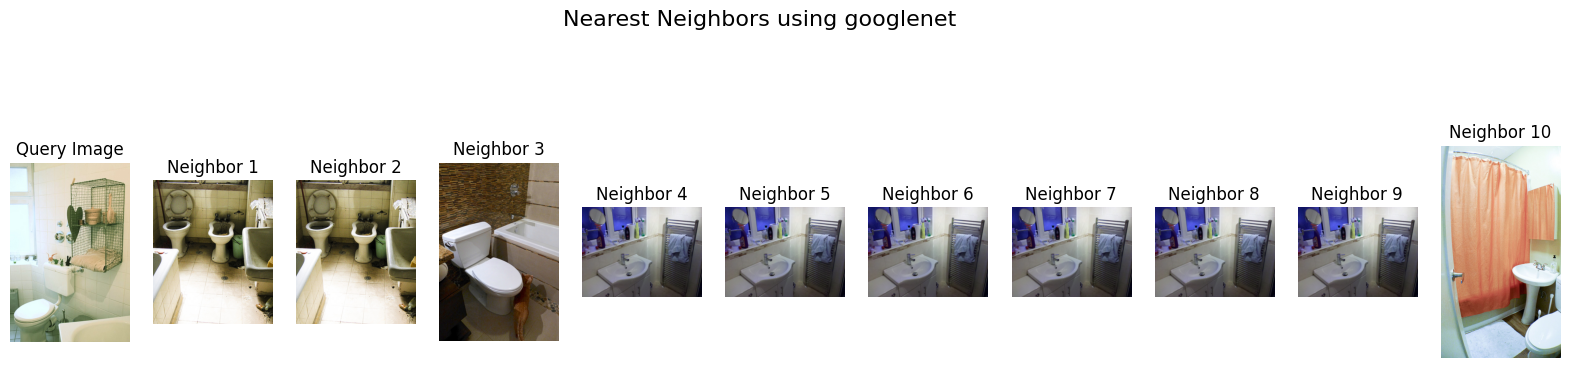


Visualizing results for zfnet:
Class: person


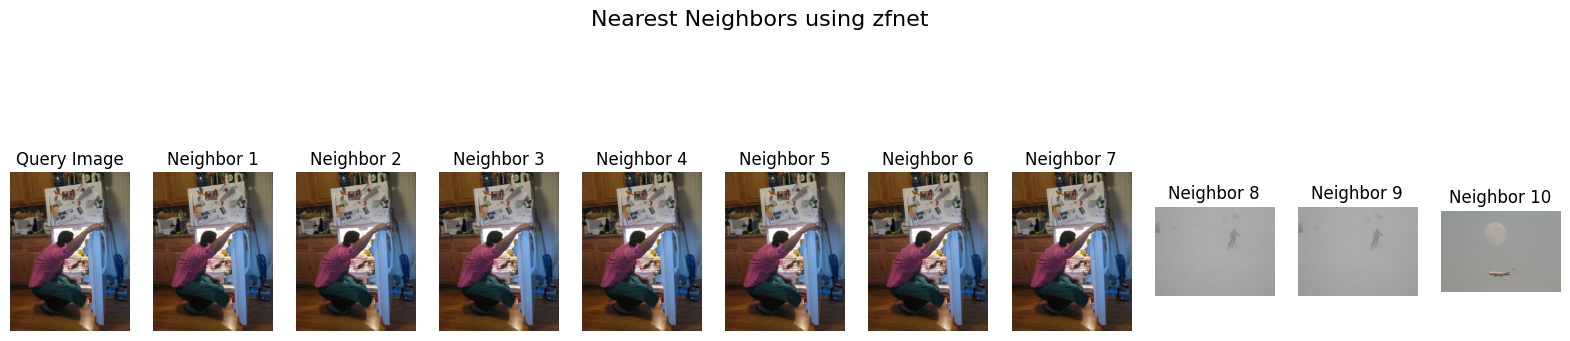

Class: car


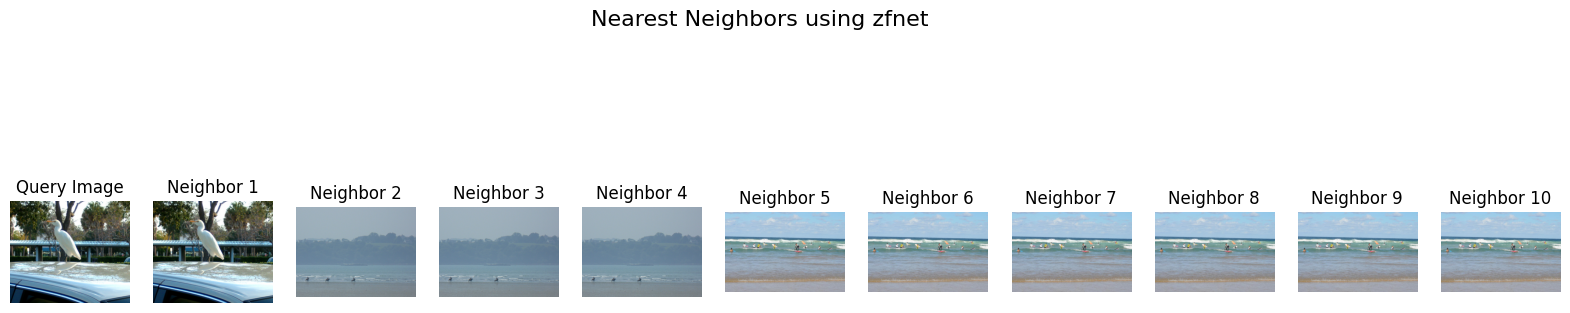

Class: dog


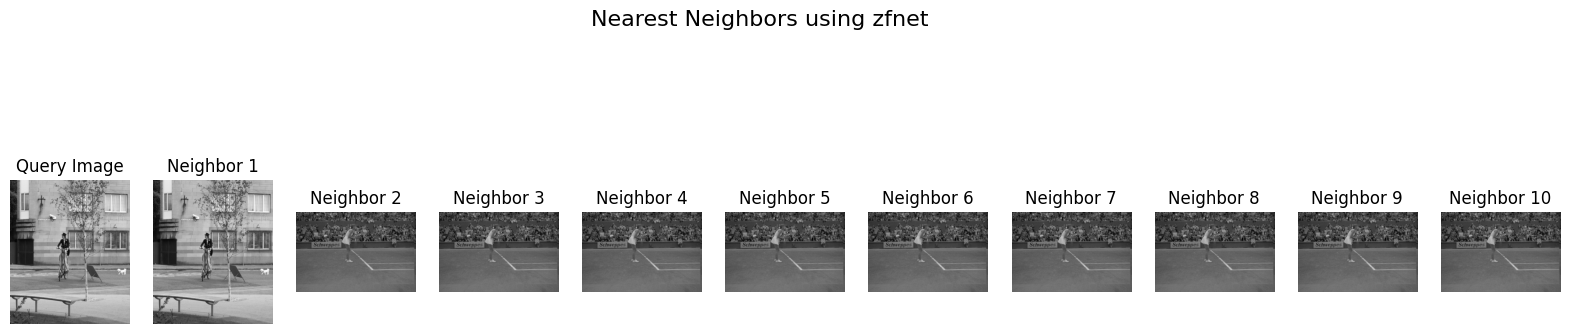

Class: cat


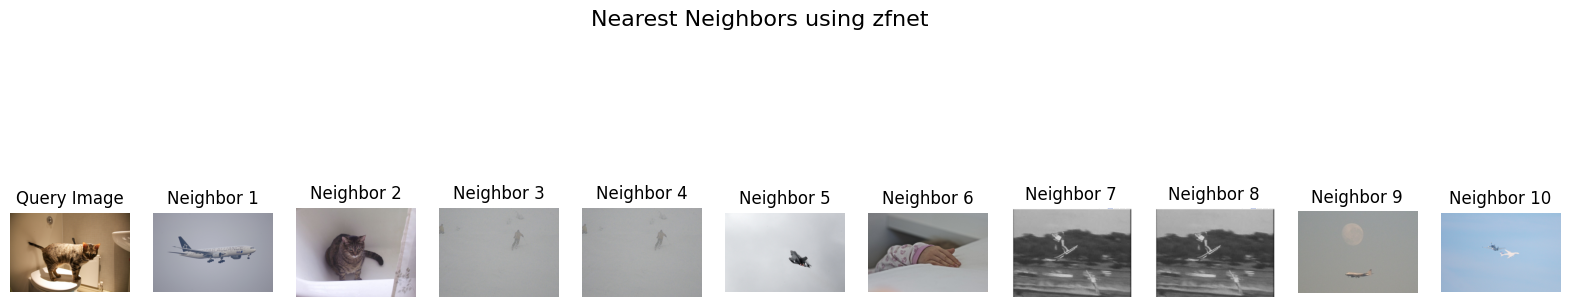

Class: airplane


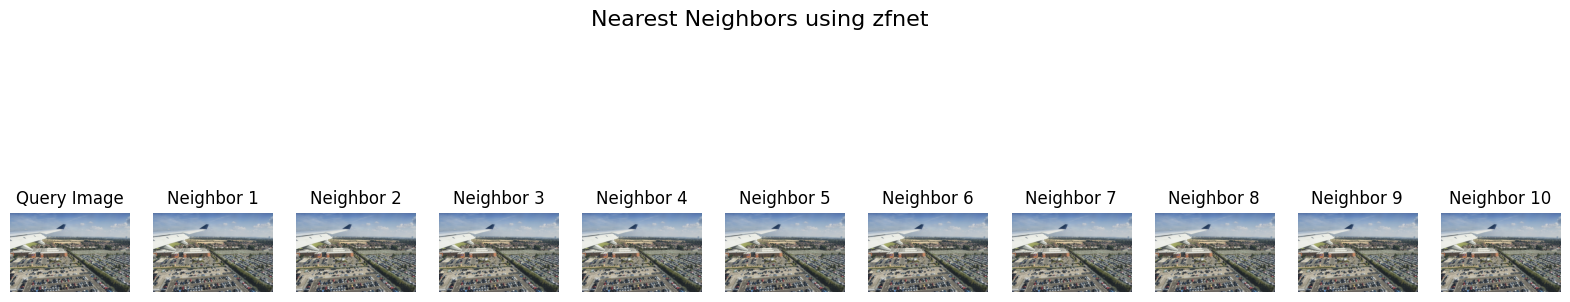

Class: bottle


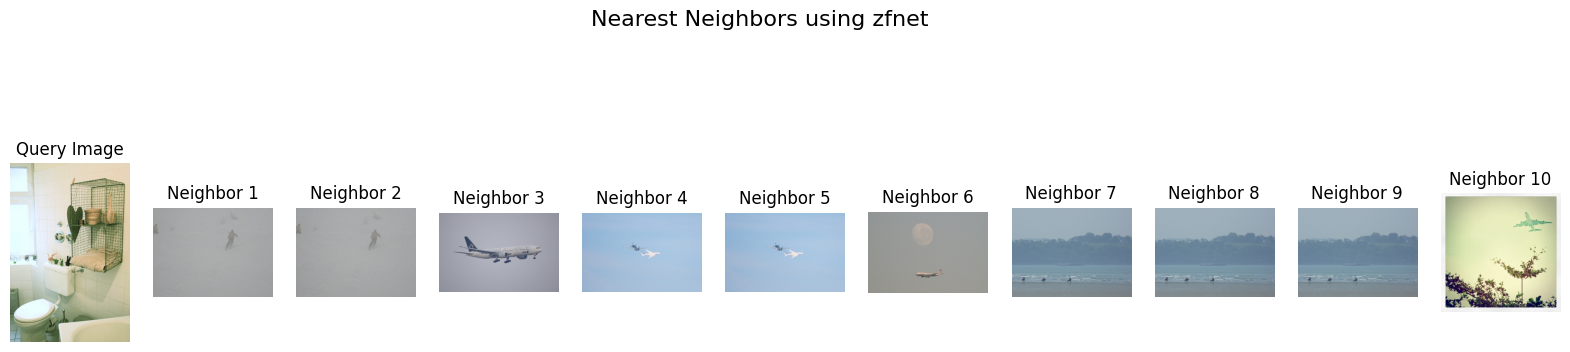

In [29]:
for model_name in models_dict.keys():
    print(f"\nVisualizing results for {model_name}:")
    features, labels = feature_dict[model_name]
    for cls, img_idx in selected_images.items():
        print(f"Class: {cls}")
        visualize_neighbors(features, labels, img_idx, image_paths, model_name)
